In [1]:
%matplotlib inline

import mne_connectivity

from _helper_functions import simulate_connectivity, plot_connectivity

## Frequency-resolved connectivity - the `mne-connectivity` package

A common analysis in neuroscience is to compute the connectivity between signals, from which we can make inferences about the communication between different regions of the brain.

In particular, we are often interested in the frequency-specific coupling of signals, often termed effective/spectral/oscillatory connectivity.

Thankfully, MNE has a sister package, [MNE-Connectivity](https://mne.tools/mne-connectivity/stable/index.html), for doing just that!

### Part 1 - Simulating connectivity

Above, we import a custom helper function `simulate_connectivity()` which generates some signals with interactions at a given frequency range (feel free to check out this function in the [_helper_functions.py](_helper_functions.py) file).

We will use this as a starting point to explore connectivity computations in MNE.

We start by simulating 2 interacting channels (1 seed and 1 target) in the frequency range 5-10 Hz.

In [2]:
# Simulate 5-10 Hz connectivity
epochs_5_10 = simulate_connectivity(n_seeds=1, n_targets=1, freq_band=(5, 10))

**Exercises - Simulating connectivity**

**Exercise:** Verify that activity is present in the 5-10 Hz frequency range of these channels by computing the power spectra of the data.

*Hint:* Both signals should contain activity in this frequency range.

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\sangeetha\AppData\Local\Temp\ipykernel_7056\3961488573.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs_5_10.compute_psd().plot();
c:\Users\sangeetha\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


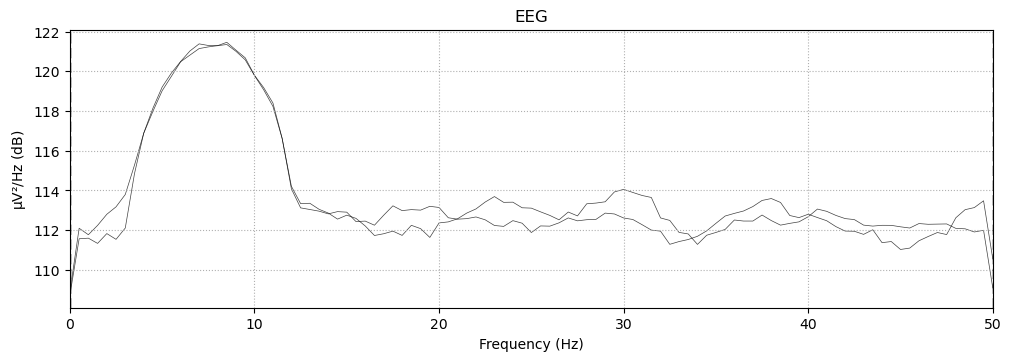

In [3]:
## CODE GOES HERE
epochs_5_10.compute_psd().plot();

**Exercise:** Simulate 2 interacting channels in the frequency range 15-20 Hz and verify that activity is present in this frequency range.

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\sangeetha\AppData\Local\Temp\ipykernel_7056\3634693051.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs_15_20.compute_psd().plot();
c:\Users\sangeetha\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


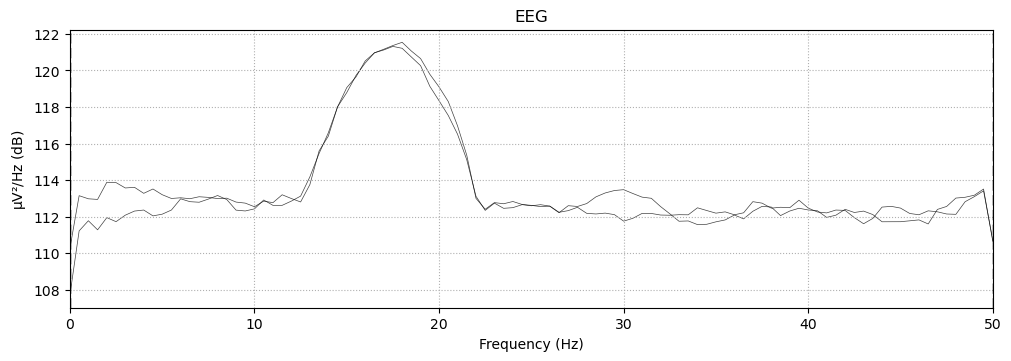

In [4]:
## CODE GOES HERE
epochs_15_20 = simulate_connectivity(n_seeds=1, n_targets=1, freq_band=(15, 20))
epochs_15_20.compute_psd().plot();

**Exercise:** Simulate 2 interacting channels in the frequency range 25-30 Hz and verify that activity is present in this frequency range.

In [ ]:
## CODE GOES HERE
epochs_25_30 = simulate_connectivity(n_seeds=1, n_targets=1, freq_band=(25, 30))
epochs_25_30.compute_psd().plot();

Now, we combine all three connectivity simulations into a single `Epochs` object using the [`add_channels()`](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.add_channels) method.

In [ ]:
# Combine epochs into a single object
epochs = epochs_5_10.copy().add_channels([epochs_15_20, epochs_25_30])
epochs.compute_psd().plot();

### Part 2 - The `spectral_connectivity_epochs()` function

We will use the function [`mne_connectivity.spectral_connectivity_epochs()`](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_epochs.html#mne_connectivity.spectral_connectivity_epochs) to compute connectivity between the simulated signals.

By default, connectivity is computed between all channels using the coherence method.

In [ ]:
# Compute coherence between all channels
connectivity = mne_connectivity.spectral_connectivity_epochs(data=epochs)

#### Formatting of connectivity results

As you can see from the logging output, without specifying which channels to compute connectivity between, 15 connections are computed. This corresponds to the number of unique combinations of our channels (`channels * (channels - 1) / 2`), e.g.:<br>
<img src="figures/connectivity_vector.png" alt="Connectivity vector" width="25%" height="25%">

However, such all-to-all connectivity results can also be represented as a dense array of shape `(channels, channels, frequencies)`, where the lower triangular elements are filled with the connectivity results, and all other elements are zeros, e.g.:<br>
<img src="figures/connectivity_matrix.png" alt="Connectivity matrix" width="30%" height="30%">


This makes indexing the results easier, and is what MNE returns when no channels are specified. Hence, 36 connections are actually returned ($6^2$, with only the lower triangular elements filled).

For an undirected connectivity measure like coherence, the upper triangular elements are identical to the lower triangular elements, so do not need to be computed.

Additionally, the diagonal elements represent the connectivity of each channel with itself and are always 1, so do not need to be computed.

These elements which are not computed are simply set to 0.

#### Extracting connectivity results

The results are returned as a [`SpectralConnectivity`](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.SpectralConnectivity.html#mne_connectivity.SpectralConnectivity) object, and the array of results can be accessed with the [`get_data()`](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.SpectralConnectivity.html#mne_connectivity.SpectralConnectivity.get_data) method.

By default, `get_data()` returns the results as a raveled array with shape `(connections, frequencies)`.

In [ ]:
# Get compact results (default)
print(f"Results shape (default): {connectivity.get_data().shape}")

This behaviour can also be specified using the `output` parameter of `get_data()`.

In [ ]:
# Get compact results (explicit)
print(f"Results shape (`output='compact'`): {connectivity.get_data(output='compact').shape}")

We can also specify `get_data()` to return the results in the dense array form with shape `(channels, channels, frequencies)` by setting `output="dense"`.

This will be easier to index for the following exercises.

In [ ]:
# Get dense results
print(f"Results shape (`output = 'dense'`): {connectivity.get_data(output='dense').shape}")

The frequencies corresponding to the connectivity results are stored as a list and can be accessed under the `freqs` attribute.

In [ ]:
# Inspect frequencies of the results
print(f"Range of frequencies: {connectivity.freqs[0]} - {connectivity.freqs[-1]} Hz")
print(f"Number of frequencies: {len(connectivity.freqs)}")
print(f"Frequencies: {connectivity.freqs}")

Below, we extract the connectivity information for the 5-10 Hz interaction between channel 0 and channel 1.

*Hint:* Because the connectivity results are stored in the lower-triangular elements, the positions of the seed and target channels must be switched. See also:<br>
<img src="figures/connectivity_matrix_highlighted.png" alt="Highlighted connectivity matrix" width="30%" height="30%">

Plotting the results shows that these are the connectivity results for the 5-10 Hz interaction.

We use the custom helper function `plot_connectivity()` to visualise the results, passing in the connectivity results for a single connection as an array and the corresponding frequencies of the results.

In [ ]:
# Plot connectivity for the 5-10 Hz interaction
conn_5_10 = connectivity.get_data("dense")[1, 0]  # (target index, seed index)
plot_connectivity(conn_5_10, connectivity.freqs)

**Exercises - extracting connectivity results**

**Exercise:** Extract and plot the connectivity information for the 15-20 Hz interaction.

*Hint:* This involved channels 2 and 3.

In [ ]:
## CODE GOES HERE
conn_15_20 = connectivity.get_data("dense")[3, 2]
plot_connectivity(conn_15_20, connectivity.freqs)

**Exercise:** Extract and plot the connectivity information for the 25-30 Hz interaction.

In [ ]:
## CODE GOES HERE
conn_25_30 = connectivity.get_data("dense")[5, 4]
plot_connectivity(conn_25_30, connectivity.freqs)

### Part 3 - The `indices` parameter

Of course, it is inefficient to compute all combinations of connections if we are only interested in a few of them. This is where the `indices` parameter is needed.

Connection indices in MNE take the form of a tuple of two array-likes, specifying the seed and target channels, respectively, e.g. `indices = (seeds, targets)`. Connectivity will be computed for only these particular combinations.

Here, we specify that connectivity should only be computed between channels 0 and 1 (the 5-10 Hz interaction) with `indices = ([0], [1])`.

In [ ]:
# Compute coherence between 5-10 Hz interacting channels
connectivity_5_10 = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([0], [1]))

From the logging output, we can see that only one connection is computed.

Accordingly, when we call `get_data()`, there is only one connection to index, and plotting the results show us we have indeed selected the 5-10 Hz interaction.

In [ ]:
# Plot connectivity for the 5-10 Hz interaction
print(f"Connectivity results shape: {connectivity_5_10.get_data().shape} (connections x frequencies)")
plot_connectivity(connectivity_5_10.get_data()[0], connectivity_5_10.freqs)

**Exercises - Specifying the indices**

**Exercise:** Compute and plot connectivity for only the 15-20 Hz interacting channels.

In [ ]:
## CODE GOES HERE
connectivity_15_20 = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([2], [3]))
print(connectivity_15_20.get_data().shape)
plot_connectivity(connectivity_15_20.get_data()[0], connectivity_15_20.freqs)

**Exercise:** Compute and plot connectivity for only the 25-30 Hz interacting channels.

In [ ]:
## CODE GOES HERE
connectivity_25_30 = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([4], [5]))
print(connectivity_25_30.get_data().shape)
plot_connectivity(connectivity_25_30.get_data()[0], connectivity_25_30.freqs)

Alternatively, we can specify multiple connections at once by providing multiple seeds and targets.

**Exercise:** Compute connectivity for the 5-10 and 15-20 Hz interacting channels (i.e. 2 connections) in a single call to `spectral_connectivity_epochs()`, and plot the connectivity values.

In [ ]:
## CODE GOES HERE
connectivity = mne_connectivity.spectral_connectivity_epochs(data=epochs, indices=([0, 2], [1, 3]))
print(connectivity.get_data().shape)
for con_i in range(connectivity.get_data().shape[0]):
    plot_connectivity(connectivity.get_data()[con_i], connectivity.freqs)

**Exercise:** Compute connectivity for the 5-10, 15-20, and 25-30 Hz interacting channels (i.e. 3 connections) in a single call to `spectral_connectivity_epochs()`, and plot the connectivity values.

In [ ]:
## CODE GOES HERE
connectivity = mne_connectivity.spectral_connectivity_epochs(
    data=epochs, indices=([0, 2, 4], [1, 3, 5])
)
print(connectivity.get_data().shape)
for con_i in range(connectivity.get_data().shape[0]):
    plot_connectivity(connectivity.get_data()[con_i], connectivity.freqs)

By specifying the `indices` parameter, we can be much more efficient by only computing the connections we are interested in.

### Part 4 - The `method` parameter

Until now, we have been using the default connectivity method - `"coh"` (coherence). However, several such methods are available depending on the sort of connectivity you are interested in, specified using the `method` parameter.

The available connectivity methods are:
- coherence - `coh`
- coherency - `cohy`
- imaginary part of coherency - [`imcoh`](https://doi.org/10.1016/j.clinph.2004.04.029)
- phase-locking value - [`plv`](https://doi.org/10.1002/(SICI)1097-0193(1999)8:4%3C194::AID-HBM4%3E3.0.CO;2-C)
- corrected imaginary phase-locking value - [`ciplv`](https://doi.org/10.1088/1741-2552/aacfe4)
- pairwise phase consistency - [`ppc`](https://doi.org/10.1016/j.neuroimage.2010.01.073)
- phase lag index - [`pli`](https://doi.org/10.1002/hbm.20346)
- unbiased squared phase lag index - [`pli2_unbiased`](https://doi.org/10.1016/j.neuroimage.2011.01.055)
- directed phase lag index  - [`dpli`](https://doi.org/10.1016/j.neuroimage.2012.05.050)
- weighted phase lag index - [`wpli`](https://doi.org/10.1016/j.neuroimage.2011.01.055)
- debiased squared weighted phase lag index [`wpli2_debiased`](https://doi.org/10.1016/j.neuroimage.2011.01.055)

References and relevant equations are given in the [documentation](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_epochs.html#mne_connectivity.spectral_connectivity_epochs).

The specifics of each method are not relevant here, but as you can see, there are many tools available in MNE-Connectivity suited to various signal analysis problems.

#### Specifying the connectivity method 

`method` can be specified as a string for a single method, or a list of strings for multiple methods.

To start off, we can explicitly pass coherence (`"coh"`) as the desired method.

Using the `method` attribute of the `SpectralConnectivity` object, we can verify that coherence has been computed.

Furthermore, we can plot the results for the 15-20 Hz interaction and verify that they match the results above.

In [ ]:
# Compute coherence (explicit)
coh = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="coh")
coh_15_20 = coh.get_data("dense")[3, 2]

plot_connectivity(coh_15_20, connectivity.freqs)
print(f"The computed method is: {coh.method}")

**Exercises - Specifying the connectivity method**

**Exercise:** Compute connectivity using the imaginary part of coherency (`"imcoh"`) and plot the results for the 15-20 Hz interaction.

How do the results compare for coherence and the imaginary part of coherency?

In [ ]:
## CODE GOES HERE
imcoh = mne_connectivity.spectral_connectivity_epochs(data=epochs, method="imcoh")
imcoh_15_20 = imcoh.get_data("dense")[3, 2]
plot_connectivity(imcoh_15_20, connectivity.freqs)
print(f"The computed method is: {imcoh.method}")

**Exercise:** Compute connectivity using coherence and the imaginary part of coherency in the same function call.

What do you notice about the output of the function?

In [ ]:
## CODE GOES HERE
con_methods = mne_connectivity.spectral_connectivity_epochs(
    data=epochs, method=["coh", "imcoh"]
)

**Exercise:** Try to access the results for each of the connectivity methods computed above.

What do you notice about the order in which the results for each method is returned?

In [ ]:
## CODE GOES HERE
for con_method in con_methods:
    print(con_method.method)

## Conclusion

As you can see, frequency-resolved connectivity analyses in MNE can easily be performed using the MNE-Connectivity package.

A wide range of connectivity methods are supported, which either come in the form of the more traditional connectivity-over-epochs discussed here (`spectral_connectivity_epochs()`), or an alternative connectivity-over-time ([`spectral_connectivity_time()`](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_time.html#mne_connectivity.spectral_connectivity_time)).

In addition, MNE-Connectivity has functions for computing vector autoregressive models ([`vector_auto_regression()`](https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.vector_auto_regression.html)), as well as [visualisation tools](https://mne.tools/mne-connectivity/stable/api.html#visualization-functions).


## Additional resources

MNE tutorial on computing all-to-all connectivity in sensor space: https://mne.tools/mne-connectivity/stable/auto_examples/sensor_connectivity.html

MNE tutorial on computing connectivity in source space: https://mne.tools/mne-connectivity/stable/auto_examples/mne_inverse_coherence_epochs.html